# Case Study 2 : Hospital Readmission

Submitted by:

- Ravi Sivaraman
- Balaji Avvaru
- Apurv Mittal

The code for importing the data is combined with the inital loading of various analysis and visualization packages below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
# read diabetic csv files
diabetic_df = pd.read_csv('/Users/ravis/Downloads/dataset_diabetes/diabetic_data.csv')
diabetic_df.shape

(101766, 50)

In [3]:
# Validate null values in the csv file
diabetic_df.isnull().sum().sum()

0

There are no null values in the dataset, but null values are coded as ?, first replace observations value ? with nan

In [4]:
# replace ? with nan
diabetic_df = diabetic_df.replace("?",np.nan)

In [5]:
# Validate null values in the csv file
print(diabetic_df.isnull().sum())
# print columns with null values
missing_data_columns = diabetic_df.columns[diabetic_df.isnull().any()]
print("\n\nColumns with null values")
print("************************")
missing_data_columns

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Index(['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3'],
      dtype='object')

In [6]:
# percentage of missing values in each variable
diabetic_df[missing_data_columns].isnull().sum()/len(diabetic_df)*100

race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

In [7]:
diabetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

##### Target variable

In [8]:
# Convert target variable to a categorical 
diabetic_df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

There are three different values for target variable. We decided to reduce these values to two based on whether readmitted ot not (0 means not admitted and 1 means admitted) 

In [9]:
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('>30', 0)
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('<30', 1)
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('NO', 0)

In [10]:
diabetic_df['readmitted'].value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

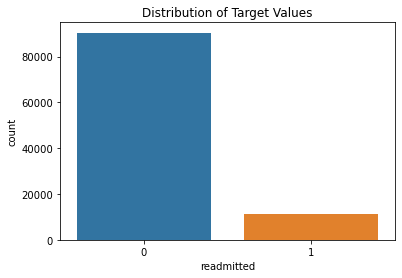

In [11]:
sns.countplot(x = "readmitted", data = diabetic_df)
plt.title("Distribution of Target Values")
plt.show()

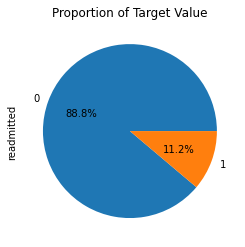

In [12]:
# Pie chart
diabetic_df.readmitted.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

These two diagrams show us that our target variable is not balanced.

##### Missing data analysis and applying Imputation

In [13]:
missing_data_columns

Index(['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3'],
      dtype='object')

## Apruv

In [14]:
data_reduced = diabetic_df[["race", "gender", "age", "weight"]]


In [15]:
data_reduced["gender"] = [1 if x=="Male" else 0 for x in data_reduced["gender"]]

In [16]:
data_reduced['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [17]:
# replacing the missing race values with Caucasian
data_reduced['race'] = data_reduced['race'].fillna("Caucasian")

### Race column

In [18]:
# One hot encoding Race
data_reduced_race = pd.get_dummies(data_reduced.race, prefix='race')
data_reduced_race=data_reduced_race.astype(float)

### Age column

In [19]:
# One hot encoding age
data_reduced_age = pd.get_dummies(data_reduced.age, prefix='age')
data_reduced_age=data_reduced_age.astype(float)

In [20]:
data_reduced_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   age_[0-10)    101766 non-null  float64
 1   age_[10-20)   101766 non-null  float64
 2   age_[20-30)   101766 non-null  float64
 3   age_[30-40)   101766 non-null  float64
 4   age_[40-50)   101766 non-null  float64
 5   age_[50-60)   101766 non-null  float64
 6   age_[60-70)   101766 non-null  float64
 7   age_[70-80)   101766 non-null  float64
 8   age_[80-90)   101766 non-null  float64
 9   age_[90-100)  101766 non-null  float64
dtypes: float64(10)
memory usage: 7.8 MB


In [21]:
#Concat
# creating DF of one hot encoded values
data = pd.concat([data_reduced,data_reduced_race,data_reduced_age],axis=1)


In [22]:
# drop race, age as its duplicate now
data=data.drop(["race", "age"], axis=1)


### Weight

In [23]:
# checking values for weight
print("Weight values",data['weight'].value_counts())

# replacinf Weight values with average of the range

data['weight'] = data['weight'].replace('[0-25)', np.nan)
data['weight'] = data['weight'].replace('[25-50)', 37.5)
data['weight'] = data['weight'].replace('[50-75)', 62.5)
data['weight'] = data['weight'].replace('[75-100)', 87.5)
data['weight'] = data['weight'].replace('[100-125)', 112.5)
data['weight'] = data['weight'].replace('[125-150)', 137.5)
data['weight'] = data['weight'].replace('[150-175)', 162.5)
data['weight'] = data['weight'].replace('[175-200)', 187.5)
data['weight'] = data['weight'].replace('>200', 250)

Weight values [75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64


In [24]:
# assigning all missing data rows to test data set
test_data = data[data["weight"].isna()]

In [25]:
# running regression to predict missing weight values
df_wona = data.dropna(axis=0)

y_train = df_wona["weight"]
X_train = df_wona.drop("weight", axis=1)
X_test = test_data.drop("weight", axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# reference: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

#### Imputing weights

In [26]:
X_test['weight'] = y_pred
df_new = pd.concat([df_wona, X_test], axis=0)
df_new.sort_index(axis = 0)
diabetic_df.drop(['weight','age', 'race', 'gender'], axis =1, inplace=True)
diabetic_df = pd.concat([diabetic_df, df_new], axis=1)

##### Discharge Disposition ID

In [27]:

diabetic_df['discharge_disposition_id'].describe()

count    101766.000000
mean          3.715642
std           5.280166
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          28.000000
Name: discharge_disposition_id, dtype: float64

There are 30 distinct values. This variable will tell whether the patient discharged to home or any other facility etc

- 1	Discharged to home 
- 2	Discharged/transferred to another short term hospital
- 3	Discharged/transferred to SNF
- 4	Discharged/transferred to ICF
- 5	Discharged/transferred to another type of inpatient care institution
- 6	Discharged/transferred to home with home health service
- 7	Left AMA
- 8	Discharged/transferred to home under care of Home IV provider
- 9	Admitted as an inpatient to this hospital
- 10	Neonate discharged to another hospital for neonatal aftercare
- 11	Expired
- 12	Still patient or expected to return for outpatient services
- 13	Hospice / home
- 14	Hospice / medical facility
- 15	Discharged/transferred within this institution to Medicare approved swing bed
- 16	Discharged/transferred/referred another institution for outpatient services
- 17	Discharged/transferred/referred to this institution for outpatient services
- 18	NULL
- 19	Expired at home. Medicaid only, hospice.
- 20	Expired in a medical facility. Medicaid only, hospice.
- 21	Expired, place unknown. Medicaid only, hospice.
- 22	Discharged/transferred to another rehab fac including rehab units of a hospital .
- 23	Discharged/transferred to a long term care hospital.
- 24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
- 25	Not Mapped
- 26	Unknown/Invalid
- 30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
- 27	Discharged/transferred to a federal health care facility.
- 28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
- 29	Discharged/transferred to a Critical Access Hospital (CAH).

In [28]:
diabetic_df["weight"]

0          32.342773
1          54.756836
2          75.225586
3          94.413086
4         100.889648
             ...    
101761     90.506836
101762     73.206055
101763     90.432617
101764     73.131836
101765     90.432617
Name: weight, Length: 101766, dtype: float64

In [29]:
diabetic_df['discharge_disposition_id'].value_counts()

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

We can make all these observations with respect to discharge_disposition_id into three different categories Home and other. The categories  18-NULL, 25-Not Mapped and 26-Unknown/Invalid are comes under NULL values. We need imputation for these categories. We decided to combine these categories with other categories.

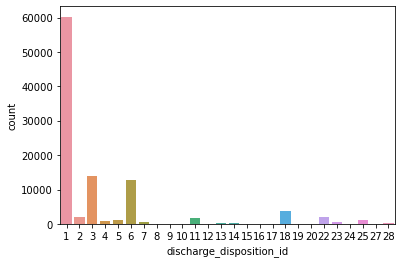

In [30]:
sns.countplot(x ="discharge_disposition_id", data = diabetic_df)
plt.show()

In [31]:
mapped_discharge = {1:"Home",
                    6:"Home",
                    8:"Home",
                    13:"Home",
                    19:"Home",
                    18:"Other",25:"Other",26:"Other",
                    2:"Other",3:"Other",4:"Other",
                    5:"Other",7:"Other",9:"Other",
                    10:"Other",11:"Other",12:"Other",
                    14:"Other",15:"Other",16:"Other",
                    17:"Other",20:"Other",21:"Other",
                    22:"Other",23:"Other",24:"Other",
                    27:"Other",28:"Other",29:"Other",30:"Other"}

diabetic_df["discharge_disposition_id"] = diabetic_df["discharge_disposition_id"].replace(mapped_discharge)

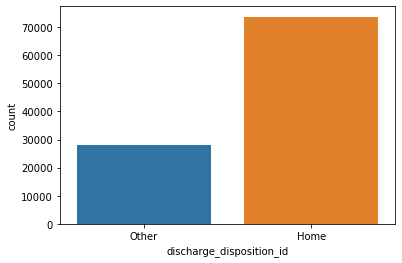

In [32]:
sns.countplot(x ="discharge_disposition_id", data = diabetic_df)
plt.show()

##### Combine Unknown into other category and explain the reason in the report

In [33]:
print("Proportions of ID's")
print(diabetic_df.discharge_disposition_id.value_counts())

Proportions of ID's
Home     73651
Other    28115
Name: discharge_disposition_id, dtype: int64


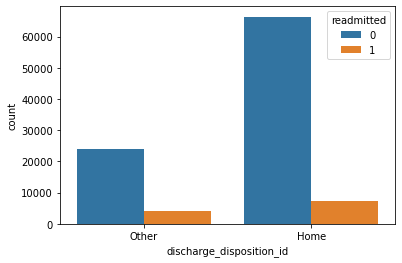

In [34]:
sns.countplot(x ="discharge_disposition_id", hue = "readmitted", data = diabetic_df)
plt.show()

In [35]:
diabetic_df['discharge_disposition_id']

0         Other
1          Home
2          Home
3          Home
4          Home
          ...  
101761    Other
101762    Other
101763     Home
101764    Other
101765     Home
Name: discharge_disposition_id, Length: 101766, dtype: object

##### Admission Source ID

In [36]:
diabetic_df['admission_source_id'].describe()

count    101766.000000
mean          5.754437
std           4.064081
min           1.000000
25%           1.000000
50%           7.000000
75%           7.000000
max          25.000000
Name: admission_source_id, dtype: float64

There are 26 distinct values. This variable will tell whether the patient admitted becuase of physician referral or clinic referral etc

- 1	 Physician Referral
- 2	Clinic Referral
- 3	HMO Referral
- 4	Transfer from a hospital
- 5	 Transfer from a Skilled Nursing Facility (SNF)
- 6	 Transfer from another health care facility
- 7	 Emergency Room
- 8	 Court/Law Enforcement
- 9	 Not Available
- 10	 Transfer from critial access hospital
- 11	Normal Delivery
- 12	 Premature Delivery
- 13	 Sick Baby
- 14	 Extramural Birth
- 15	Not Available
- 17	NULL
- 18	 Transfer From Another Home Health Agency
- 19	Readmission to Same Home Health Agency
- 20	 Not Mapped
- 21	Unknown/Invalid
- 22	 Transfer from hospital inpt/same fac reslt in a sep claim
- 23	 Born inside this hospital
- 24	 Born outside this hospital
- 25	 Transfer from Ambulatory Surgery Center
- 26	Transfer from Hospice


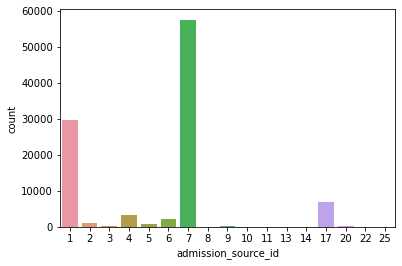

In [37]:
sns.countplot(x ="admission_source_id", data = diabetic_df)
plt.show()

We can make all observations with respect to admission source into three different categories like, Referral, Emergency or  Other

In [38]:
# map the admission source to three categories
mapped_adm = {1:"Referral",2:"Referral",3:"Referral",
              4:"Other",5:"Other",6:"Other",10:"Other",22:"Other",25:"Other",
              9:"Other",8:"Other",14:"Other",13:"Other",11:"Other",
              15:"Other",17:"Emergency",20:"Referral",21:"Other",
              7:"Emergency"}

# replace the admisision values to three categories
diabetic_df.admission_source_id = diabetic_df.admission_source_id.replace(mapped_adm)

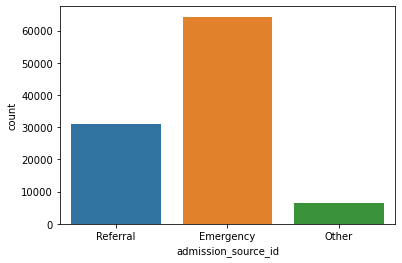

In [39]:
sns.countplot(x = "admission_source_id", data = diabetic_df)
plt.show()

In [40]:
print(diabetic_df.admission_source_id.value_counts())

Emergency    64275
Referral     31017
Other         6474
Name: admission_source_id, dtype: int64


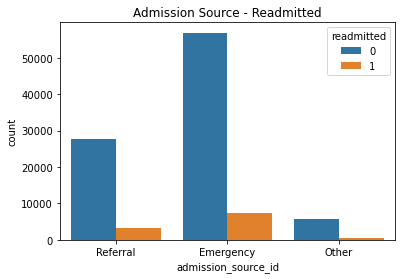

In [41]:
sns.countplot(x = "admission_source_id", hue = "readmitted", data = diabetic_df)
plt.title("Admission Source - Readmitted")
plt.show()

In [42]:
diabetic_df.columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'gender', 'weight', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'age_[

### max_glu_serum column

In [43]:
diabetic_df["max_glu_serum"].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

In [44]:
# Get one hot encoding of A1Cresult
one_hot_max_glu_s = pd.get_dummies(diabetic_df["max_glu_serum"], prefix="mgs")
# Drop column diabetic_df as it is now encoded
diabetic_df = diabetic_df.drop('max_glu_serum',axis = 1)
# Join the encoded df
diabetic_df = diabetic_df.join(one_hot_max_glu_s)

### a1c


In [45]:
# Get one hot encoding of A1Cresult
one_hot_a1c = pd.get_dummies(diabetic_df["A1Cresult"], prefix="a1c")
# Drop column diabetic_df as it is now encoded
diabetic_df = diabetic_df.drop('A1Cresult',axis = 1)
# Join the encoded df
diabetic_df = diabetic_df.join(one_hot_a1c)

### number_diagnoses

leaving them as int.

In [46]:
diabetic_df["number_inpatient"].value_counts()

0     67630
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
21        1
18        1
Name: number_inpatient, dtype: int64

### num_medications

### number_outpatient         
      


### number_emergency   

### number_inpatient

In [47]:
diabetic_df["glipizide"].value_counts()

No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64

##### time_in_hospital

This is integer variable, this will tell how many days patient stayed in the hospital

In [48]:
diabetic_df['time_in_hospital'].describe()

count    101766.000000
mean          4.395987
std           2.985108
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64

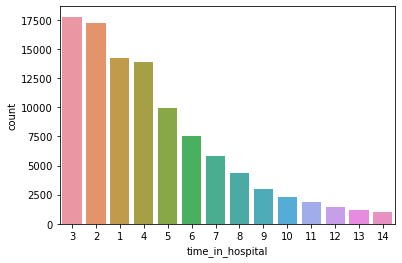

<Figure size 720x360 with 0 Axes>

In [49]:
sns.countplot(x="time_in_hospital", data = diabetic_df,
              order = diabetic_df.time_in_hospital.value_counts().index)
fig = plt.figure(figsize=(10,5))
plt.show()

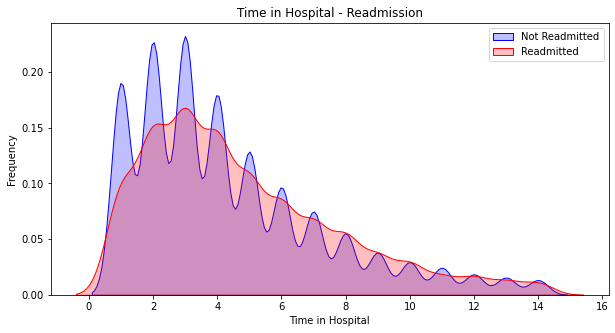

In [50]:
fig = plt.figure(figsize=(10,5))
#readmitted = 0
ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 0), "time_in_hospital"],
                 color = "b", shade = True, label = "Not Readmitted")

ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 1), "time_in_hospital"],
                 color = "r", shade = True, label = "Readmitted")
ax.legend(loc="upper right")

ax.set_xlabel("Time in Hospital")
ax.set_ylabel("Frequency")
ax.set_title("Time in Hospital - Readmission")
plt.show()

##### payer_code 

This is object variable, this variable will tell you the insurance of the patient. This variable has 17 unique values

In [51]:
print(diabetic_df.payer_code.value_counts())

MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64


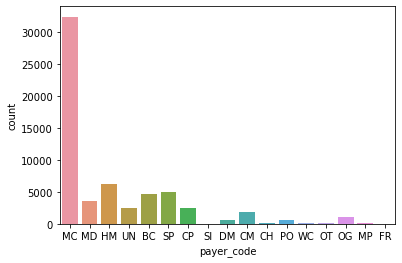

In [52]:
sns.countplot(x = "payer_code", data = diabetic_df)
plt.show()

Impute the missing values in payer_code based on frequency 

In [53]:
s = diabetic_df.payer_code.value_counts(normalize=True)
diabetic_df['payer_code_impu'] = diabetic_df['payer_code']
diabetic_df.loc[diabetic_df.payer_code.isna(), 'payer_code_impu'] = np.random.choice(s.index, p=s.values, 
                                                                          size=diabetic_df.payer_code.isna().sum())
diabetic_df

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,...,age_[90-100),mgs_>200,mgs_>300,mgs_None,mgs_Norm,a1c_>7,a1c_>8,a1c_None,a1c_Norm,payer_code_impu
0,2278392,8222157,6,Other,Referral,1,NaN,Pediatrics-Endocrinology,41,0,...,0.0,0,0,1,0,0,0,1,0,CP
1,149190,55629189,1,Home,Emergency,3,NaN,NaN,59,0,...,0.0,0,0,1,0,0,0,1,0,SP
2,64410,86047875,1,Home,Emergency,2,NaN,NaN,11,5,...,0.0,0,0,1,0,0,0,1,0,HM
3,500364,82442376,1,Home,Emergency,2,NaN,NaN,44,1,...,0.0,0,0,1,0,0,0,1,0,CP
4,16680,42519267,1,Home,Emergency,1,NaN,NaN,51,0,...,0.0,0,0,1,0,0,0,1,0,BC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,1,Other,Emergency,3,MC,NaN,51,0,...,0.0,0,0,1,0,0,1,0,0,MC
101762,443847782,74694222,1,Other,Other,5,MC,NaN,33,3,...,0.0,0,0,1,0,0,0,1,0,MC
101763,443854148,41088789,1,Home,Emergency,1,MC,NaN,53,0,...,0.0,0,0,1,0,0,0,1,0,MC
101764,443857166,31693671,2,Other,Emergency,10,MC,Surgery-General,45,2,...,0.0,0,0,1,0,0,0,1,0,MC


In [54]:
diabetic_df.payer_code_impu.isna().sum()

0

In [55]:
print(diabetic_df.payer_code_impu.value_counts())

MC    53626
HM    10366
SP     8364
BC     7682
MD     5778
CP     4233
UN     4065
CM     3177
OG     1698
PO     1005
DM      902
CH      261
WC      233
OT      156
MP      127
SI       92
FR        1
Name: payer_code_impu, dtype: int64


##### medical_specialty

This is integer variable, this will tell the specialty of the admitting physician. There are 72 unique values for this variable

In [56]:
print(diabetic_df.medical_specialty.value_counts())

InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
Surgery-General                      3099
                                    ...  
Perinatology                            1
Neurophysiology                         1
Psychiatry-Addictive                    1
Pediatrics-InfectiousDiseases           1
Surgery-PlasticwithinHeadandNeck        1
Name: medical_specialty, Length: 72, dtype: int64


In [57]:
# Impute the missing values in medical_specialty based on frequency
m = diabetic_df.medical_specialty.value_counts(normalize=True)
diabetic_df['medical_specialty_impu'] = diabetic_df['medical_specialty']
diabetic_df.loc[diabetic_df.medical_specialty.isna(), 'medical_specialty_impu'] = np.random.choice(m.index, p=m.values, 
                                                                          size=diabetic_df.medical_specialty.isna().sum())
diabetic_df

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,...,mgs_>200,mgs_>300,mgs_None,mgs_Norm,a1c_>7,a1c_>8,a1c_None,a1c_Norm,payer_code_impu,medical_specialty_impu
0,2278392,8222157,6,Other,Referral,1,NaN,Pediatrics-Endocrinology,41,0,...,0,0,1,0,0,0,1,0,CP,Pediatrics-Endocrinology
1,149190,55629189,1,Home,Emergency,3,NaN,NaN,59,0,...,0,0,1,0,0,0,1,0,SP,Surgery-General
2,64410,86047875,1,Home,Emergency,2,NaN,NaN,11,5,...,0,0,1,0,0,0,1,0,HM,Pediatrics-Pulmonology
3,500364,82442376,1,Home,Emergency,2,NaN,NaN,44,1,...,0,0,1,0,0,0,1,0,CP,Family/GeneralPractice
4,16680,42519267,1,Home,Emergency,1,NaN,NaN,51,0,...,0,0,1,0,0,0,1,0,BC,Orthopedics-Reconstructive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,1,Other,Emergency,3,MC,NaN,51,0,...,0,0,1,0,0,1,0,0,MC,InternalMedicine
101762,443847782,74694222,1,Other,Other,5,MC,NaN,33,3,...,0,0,1,0,0,0,1,0,MC,InternalMedicine
101763,443854148,41088789,1,Home,Emergency,1,MC,NaN,53,0,...,0,0,1,0,0,0,1,0,MC,InternalMedicine
101764,443857166,31693671,2,Other,Emergency,10,MC,Surgery-General,45,2,...,0,0,1,0,0,0,1,0,MC,Surgery-General


In [58]:
print(diabetic_df.medical_specialty_impu.value_counts())

InternalMedicine                 28703
Emergency/Trauma                 14807
Family/GeneralPractice           14600
Cardiology                       10492
Surgery-General                   6050
                                 ...  
Pediatrics-InfectiousDiseases        2
Psychiatry-Addictive                 2
Neurophysiology                      2
Proctology                           2
Speech                               2
Name: medical_specialty_impu, Length: 72, dtype: int64


We can convert all these observations with respect to medical_specialty into 9 or 10 different categories  

In [59]:
top_10=['InternalMedicine','Family/GeneralPractice','Cardiology','Surgery-General',
        "Nephrology","Orthopedics","Radiologist","Pulmonology"]

diabetic_df.loc[~diabetic_df['medical_specialty_impu'].isin(top_10),'medical_specialty_impu']='Other'

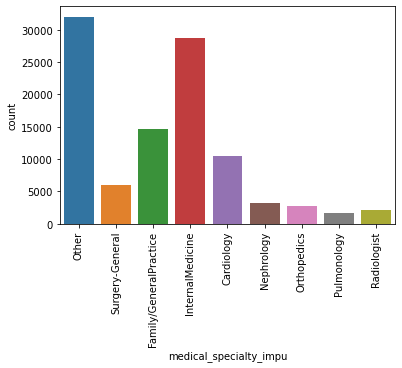

In [60]:
sns.countplot(x = "medical_specialty_impu", data = diabetic_df)
plt.xticks(rotation = 90)
plt.show()

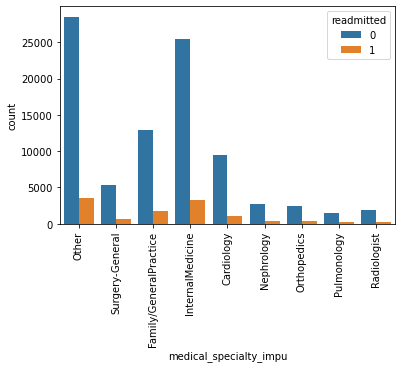

In [61]:
sns.countplot(x = "medical_specialty_impu",hue = "readmitted", data = diabetic_df)
plt.xticks(rotation = 90)
plt.show()

##### num_lab_procedures

This is integer and this will tell number of lab tests performed during hospital stay

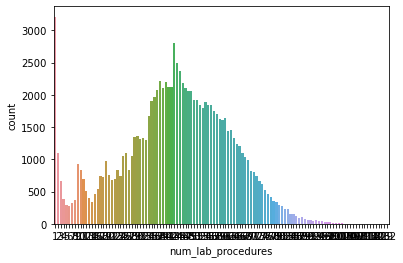

In [62]:
sns.countplot(x = "num_lab_procedures", data = diabetic_df)
plt.show()

In [63]:
print("Proportions of Column")
print(diabetic_df.num_lab_procedures.value_counts().head(10))

Proportions of Column
1     3208
43    2804
44    2496
45    2376
38    2213
40    2201
46    2189
41    2117
42    2113
47    2106
Name: num_lab_procedures, dtype: int64


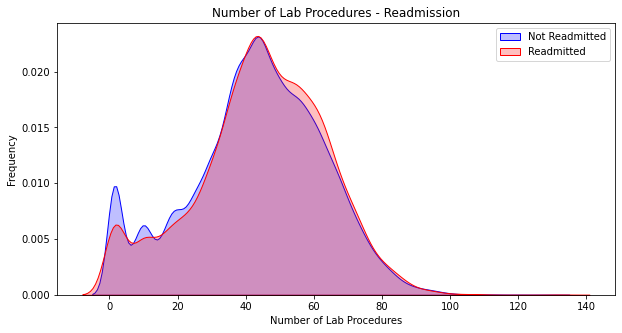

In [64]:
fig = plt.figure(figsize=(10,5))

#readmitted = 0
ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 0), "num_lab_procedures"],
                 color = "b", shade = True,label = "Not Readmitted")

#readmitted = 1
ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 1), "num_lab_procedures"],
                 color = "r", shade = True, label = "Readmitted")

ax.legend(loc="upper right")

ax.set_xlabel("Number of Lab Procedures")
ax.set_ylabel("Frequency")
ax.set_title("Number of Lab Procedures - Readmission")

plt.show()

##### num_procedures

Number of procedures (other than lab tests) performed during the encounter

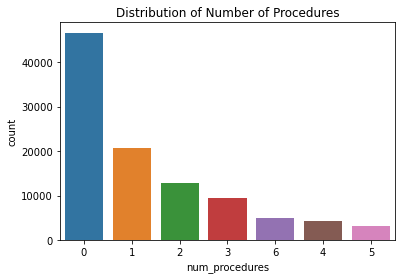

In [65]:
sns.countplot(x = diabetic_df.num_procedures, order = diabetic_df.num_procedures.value_counts().index)
plt.title("Distribution of Number of Procedures")
plt.show()

In [66]:
print("Proportions of Values")
print(diabetic_df.num_procedures.value_counts())

Proportions of Values
0    46652
1    20742
2    12717
3     9443
6     4954
4     4180
5     3078
Name: num_procedures, dtype: int64


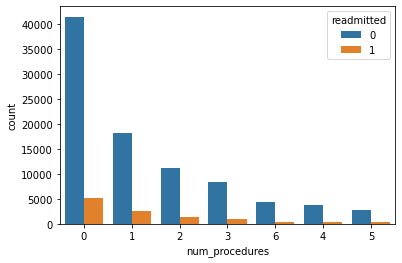

In [67]:
sns.countplot(x = "num_procedures", hue = "readmitted", 
              data = diabetic_df, order = diabetic_df.num_procedures.value_counts().index)
plt.show()

#####  glipizide                 

In [68]:
print(diabetic_df.glipizide.value_counts())
print(diabetic_df.glyburide.value_counts())
print(diabetic_df.tolbutamide.value_counts())
print(diabetic_df.pioglitazone.value_counts())
print(diabetic_df.rosiglitazone.value_counts())
print(diabetic_df.acarbose.value_counts())
print(diabetic_df.miglitol.value_counts())
print(diabetic_df.troglitazone.value_counts())
print(diabetic_df.tolazamide.value_counts())
print(diabetic_df.examide.value_counts())

No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64
No        101743
Steady        23
Name: tolbutamide, dtype: int64
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64
No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dtype: int64
No        101458
Steady       295
Up            10
Down           3
Name: acarbose, dtype: int64
No        101728
Steady        31
Down           5
Up             2
Name: miglitol, dtype: int64
No        101763
Steady         3
Name: troglitazone, dtype: int64
No        101727
Steady        38
Up             1
Name: tolazamide, dtype: int64
No    101766
Name: examide, dtype: int64


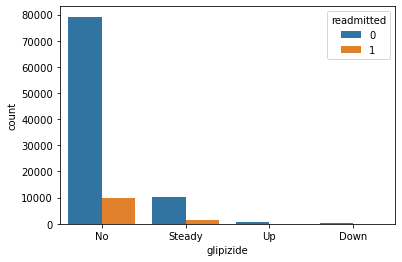

GLIPIZIDE
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64


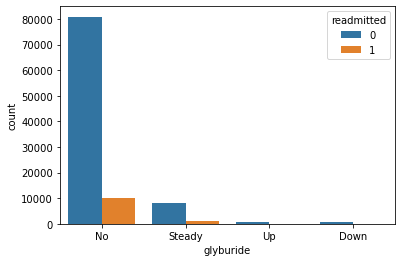

GLYBURIDE
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64


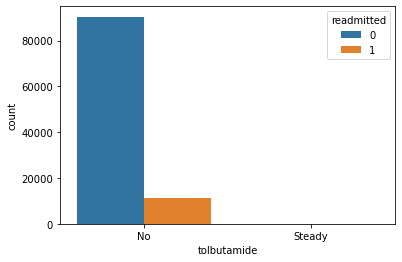

TOLBUTAMIDE
No        101743
Steady        23
Name: tolbutamide, dtype: int64


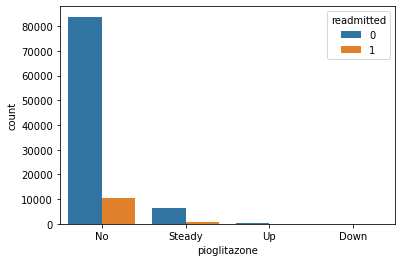

PIOGLITAZONE
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64


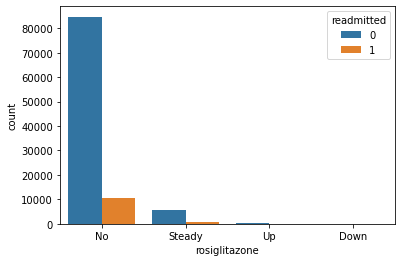

ROSIGLITAZONE
No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dtype: int64


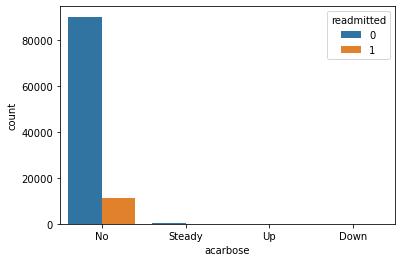

ACARBOSE
No        101458
Steady       295
Up            10
Down           3
Name: acarbose, dtype: int64


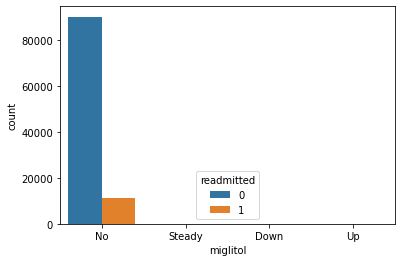

MIGLITOL
No        101728
Steady        31
Down           5
Up             2
Name: miglitol, dtype: int64


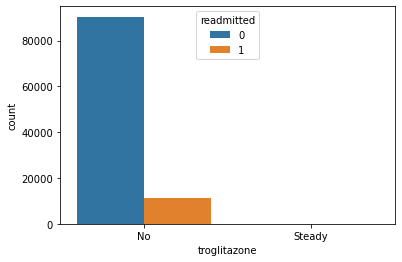

TROGLITAZONE
No        101763
Steady         3
Name: troglitazone, dtype: int64


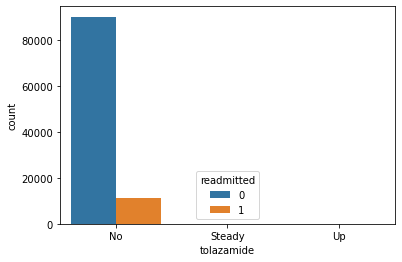

TOLAZAMIDE
No        101727
Steady        38
Up             1
Name: tolazamide, dtype: int64


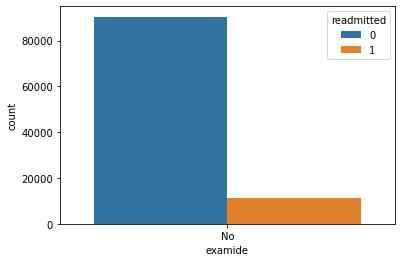

EXAMIDE
No    101766
Name: examide, dtype: int64


In [69]:
drug_cols = ['glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'examide']

def explore_drug(drugs):

    for drug in drugs:
        sns.countplot(x = drug, hue = "readmitted", data = diabetic_df)
        plt.show()
        print(drug.upper())
        print(diabetic_df[f"{drug}"].value_counts())
    

explore_drug(drug_cols)

balaji_cols = ['discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'payer_code_impu', 
               'medical_specialty', 'medical_specialty_impu', 'num_lab_procedures', 'num_procedures', 'glipizide', 'glyburide', 'tolbutamide',
               'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
               'tolazamide', 'examide', 'readmitted']

In [70]:
diabetic_df["diag_2"].unique()

array([nan, '250.01', '250', '250.43', '157', '411', '492', '427', '198',
       '403', '288', '998', '507', '174', '425', '456', '401', '715',
       '496', '428', '585', '250.02', '410', '999', '996', '135', '244',
       '41', '571', '276', '997', '599', '424', '491', '553', '707',
       '286', '440', '493', '242', '70', 'V45', '250.03', '357', '511',
       '196', '396', '197', '414', '250.52', '577', '535', '413', '285',
       '53', '780', '518', '150', '566', '250.6', '867', '486', 'V15',
       '8', '788', '340', '574', '581', '228', '530', '250.82', '786',
       '294', '567', '785', '512', '305', '729', '250.51', '280', '648',
       '560', '618', '444', '38', 'V10', '578', '277', '781', '250.42',
       '278', '426', '584', '462', '402', '153', '272', '733', '34',
       '881', '203', '250.41', '250.13', '293', '245', '250.12', '558',
       '787', '342', '573', '626', '303', '250.53', '458', '710', '415',
       'V42', '284', '569', '759', '682', '112', '292', '435', '290'

In [71]:
#balaji_df = diabetic_df[balaji_cols]

balaji_df = diabetic_df

In [72]:
## removing variables "payer_code" and "medical_specialty" with large number of missing values and also not going to impact 
## target "readmitted"

balaji_df = balaji_df.drop(['payer_code', 'medical_specialty'], axis = 1)

In [73]:
## remove all variables with less than 6 percentage variance

#balaji_df = balaji_df.drop(['examide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
#                               'acarbose', 'miglitol', 'troglitazone', ], axis = 1)

In [74]:
balaji_df.head()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,mgs_>200,mgs_>300,mgs_None,mgs_Norm,a1c_>7,a1c_>8,a1c_None,a1c_Norm,payer_code_impu,medical_specialty_impu
0,2278392,8222157,6,Other,Referral,1,41,0,1,0,...,0,0,1,0,0,0,1,0,CP,Other
1,149190,55629189,1,Home,Emergency,3,59,0,18,0,...,0,0,1,0,0,0,1,0,SP,Surgery-General
2,64410,86047875,1,Home,Emergency,2,11,5,13,2,...,0,0,1,0,0,0,1,0,HM,Other
3,500364,82442376,1,Home,Emergency,2,44,1,16,0,...,0,0,1,0,0,0,1,0,CP,Family/GeneralPractice
4,16680,42519267,1,Home,Emergency,1,51,0,8,0,...,0,0,1,0,0,0,1,0,BC,Other


Convert the categorical variables using onehot encoding


In [75]:
balaji_df_cleaned = pd.get_dummies(balaji_df, columns=['discharge_disposition_id', 'admission_source_id', 'payer_code_impu', 
                                                       'medical_specialty_impu', 'diag_1','diag_2','diag_3',
                                                       "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                                                       "glimepiride", "acetohexamide", "glipizide", "glyburide", 
                                                       "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", 
                                                       "miglitol", "troglitazone", "tolazamide", "examide", 
                                                       "citoglipton", "insulin", "glyburide-metformin", 
                                                       "glipizide-metformin", "glimepiride-pioglitazone", 
                                                       "metformin-rosiglitazone", "metformin-pioglitazone", 
                                                       "change", "diabetesMed"],
                        prefix=["Discharged_to", "Admission_source","payer_code", "medical_specialty", "diag_1","diag_2",
                                "diag_3", "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                                "glimepiride", "acetohexamide", "glipizide", "glyburide", 
                                "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", 
                                "miglitol", "troglitazone", "tolazamide","examide", 
                                "citoglipton", "insulin", "glyburide-metformin", 
                                "glipizide-metformin","glimepiride-pioglitazone", 
                                "metformin-rosiglitazone", "metformin-pioglitazone", 
                                "change", "diabetesMed"] )

In [72]:
balaji_df_cleaned.columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       ...
       'glimepiride-pioglitazone_No', 'glimepiride-pioglitazone_Steady',
       'metformin-rosiglitazone_No', 'metformin-rosiglitazone_Steady',
       'metformin-pioglitazone_No', 'metformin-pioglitazone_Steady',
       'change_Ch', 'change_No', 'diabetesMed_No', 'diabetesMed_Yes'],
      dtype='object', length=2396)

In [76]:
# Create X (Independent variables) and y(target) from the dataframe with all variables
X = balaji_df_cleaned.drop(['readmitted'],axis=1)
ind_columns = balaji_df_cleaned.drop('readmitted',axis=1).columns
y = balaji_df_cleaned['readmitted']

In [77]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [78]:
# cross validation with k=10
cv = KFold(n_splits=10, random_state=1234, shuffle=True)

#### Model 1: Logistic regression

In [79]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision','recall'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

In [80]:
# Reference https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
# ROC curve plot
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt

def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

GridSearch Parameters:

penalty: Used to specify the norm used in the penalization.  

C: Inverse of regularization strength

max_iter: Maximum number of iterations taken for the solvers to converge. 

class_weight: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to 
class frequencies in the input data .

solver:Algorithm to use in the optimization problem

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

# define parameters
#penalty_LR = ['l1', 'l2', 'elasticnet', 'none'] 
penalty_LR = [ 'l1', 'l2'] 
#C_LR = [0.001, 0.01, 0.1, 1, 10, 100]  
C_LR = [0.001,10, 100]  
max_iter_LR = [500]
#max_iter_LR = [500]
class_weight_LR = ['balanced']
#solver_LR = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
solver_LR = ['lbfgs', 'liblinear']

# define grid search
param_grid_LR = dict(penalty=penalty_LR, C=C_LR, max_iter=max_iter_LR, class_weight=class_weight_LR, solver=solver_LR)

grid_search_LR = GridSearchCV(estimator=LR, param_grid=param_grid_LR, n_jobs=7, cv=cv, 
                              scoring='accuracy',error_score=0)

In [ ]:
%%time
grid_result_LR = grid_search_LR.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (grid_result_LR.best_score_, grid_result_LR.best_params_))
means = grid_result_LR.cv_results_['mean_test_score']
stds = grid_result_LR.cv_results_['std_test_score']
params = grid_result_LR.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_LR =grid_result_LR.best_estimator_
best_Estimator_LR

In [ ]:
# Display model metrics
displayModel_metrics(best_Estimator_LR, grid_result_LR, X_scaled, y, cv)

In [ ]:
# Plot ROC curve
roc_curve_plot(grid_result_LR, X_scaled, y)

#### Learning Curves for Classifiers

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

In [ ]:
from yellowbrick.model_selection import LearningCurve

def Learning_curve_plot(model):
    # Create the learning curve visualizer
    sizes = np.linspace(0.3, 1.0, 10)
    
    visualizer = LearningCurve(
    model, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=-1)

    visualizer.fit(X_scaled, y)        # Fit the data to the visualizer
    visualizer.show()           # Finalize and render the figure

In [ ]:
!conda install yellowbrick 

In [ ]:
# Learning curve for LR classifier
Learning_curve_plot(best_Estimator_LR)

### Identify Important Attributes

In [ ]:
# recursive Feature elimination to identify important features
from sklearn.feature_selection import RFECV

# Instance of Recursive Feature Elimination
rfecv = RFECV(estimator=best_Estimator_LR, step=1, cv=cv, n_jobs=-1, scoring='accuracy')

# Fit RFE
rfecv.fit(X_scaled, y)

In [ ]:
# get column names
columns = pd.DataFrame(list(ind_columns))

# Get the ranking of features
ranking = pd.DataFrame(rfecv.ranking_)

# ranking and their importance
rfe_selected = pd.DataFrame()
rfe_selected  = pd.concat([columns, ranking], axis=1)
rfe_selected.columns = ['Feature Name', 'Ranking']
rfe_selected_sorted = rfe_selected.sort_values(by=['Ranking'], ascending=True)
print(rfe_selected_sorted)